In [23]:
# Cell 1: Setup and Imports
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
from pathlib import Path
import logging
import json

In [13]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [14]:
# Setup paths
notebook_dir = Path(os.getcwd())
project_root = notebook_dir.parent
sys.path.append(str(project_root))

In [15]:
# Import our fetcher
from scripts.data_fetcher import DarkPoolDataFetcher

In [16]:
# Configure matplotlib
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [17]:
# Set timezone to CET (Central European Time)
cet = pytz.timezone('CET')

# For reference, also set US/Eastern for market hours
eastern = pytz.timezone('US/Eastern')

In [18]:
# Define market hours in CET
MARKET_OPEN_CET = datetime.now(cet).replace(hour=15, minute=30, second=0, microsecond=0)
MARKET_CLOSE_CET = datetime.now(cet).replace(hour=22, minute=0, second=0, microsecond=0)

In [19]:
# Cell 2: Initialize Fetcher
fetcher = DarkPoolDataFetcher()

In [20]:
# Cell 3: Analysis Functions
def analyze_trades(trades_df: pd.DataFrame) -> dict:
    """Perform comprehensive analysis on trades data."""
    if trades_df.empty:
        return {}
    
    # Basic statistics
    analysis = {
        'total_trades': len(trades_df),
        'total_volume': trades_df['size'].sum(),
        'total_premium': trades_df['premium'].sum(),
        'avg_trade_size': trades_df['size'].mean(),
        'avg_price': trades_df['price'].mean(),
        'price_range': {
            'min': trades_df['price'].min(),
            'max': trades_df['price'].max(),
            'range': trades_df['price'].max() - trades_df['price'].min()
        }
    }
    
    # Time-based analysis
    trades_df['hour'] = trades_df['timestamp'].dt.hour
    hourly_stats = trades_df.groupby('hour').agg({
        'size': ['count', 'sum', 'mean'],
        'premium': 'sum',
        'price': ['min', 'max', 'mean']
    }).round(2)
    
    analysis['hourly_stats'] = hourly_stats
    
    # Market center analysis
    if 'market_center' in trades_df.columns:
        market_center_stats = trades_df.groupby('market_center').agg({
            'size': ['count', 'sum', 'mean'],
            'premium': 'sum'
        }).round(2)
        analysis['market_center_stats'] = market_center_stats
    
    # Price impact analysis
    if 'price_impact' in trades_df.columns:
        analysis['price_impact'] = {
            'mean': trades_df['price_impact'].mean(),
            'median': trades_df['price_impact'].median(),
            'std': trades_df['price_impact'].std()
        }
    
    return analysis

In [21]:
# Cell 4: Visualization Function
def plot_trade_analysis(trades_df: pd.DataFrame, analysis: dict):
    """Create visualizations for the trades data."""
    if trades_df.empty:
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Dark Pool Trade Analysis', fontsize=16)
    
    # 1. Trade Volume by Hour
    hourly_volume = trades_df.groupby('hour')['size'].sum()
    axes[0, 0].bar(hourly_volume.index, hourly_volume.values)
    axes[0, 0].set_title('Trade Volume by Hour')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Total Volume')
    
    # 2. Price Distribution
    sns.histplot(data=trades_df, x='price', bins=30, ax=axes[0, 1])
    axes[0, 1].set_title('Price Distribution')
    axes[0, 1].set_xlabel('Price')
    axes[0, 1].set_ylabel('Count')
    
    # 3. Trade Size Distribution
    sns.histplot(data=trades_df, x='size', bins=30, ax=axes[1, 0])
    axes[1, 0].set_title('Trade Size Distribution')
    axes[1, 0].set_xlabel('Trade Size')
    axes[1, 0].set_ylabel('Count')
    
    # 4. Market Center Distribution (if available)
    if 'market_center' in trades_df.columns:
        market_center_counts = trades_df['market_center'].value_counts()
        axes[1, 1].pie(market_center_counts, labels=market_center_counts.index, autopct='%1.1f%%')
        axes[1, 1].set_title('Market Center Distribution')
    
    plt.tight_layout()
    plt.show()

INFO:__main__:Fetching dark pool trades from last trading day...
INFO:scripts.data_fetcher:Fetching trades for last trading day: 2025-04-14
INFO:scripts.data_fetcher:Using endpoint: https://api.unusualwhales.com/api/darkpool/recent
INFO:scripts.data_fetcher:Request params: {'limit': 100, 'date': '2025-04-14'}
INFO:scripts.data_fetcher:Fetched 100 trades from recent endpoint
INFO:scripts.data_fetcher:Successfully processed 100 trades
INFO:scripts.data_fetcher:Total processed trades: 100



Trade Analysis Summary:
Total Trades: 100
Total Volume: 422,450
Total Premium: $23,109,791.41
Average Trade Size: 4,224.50
Average Price: $180.49
Price Range: $3.47 - $943.50


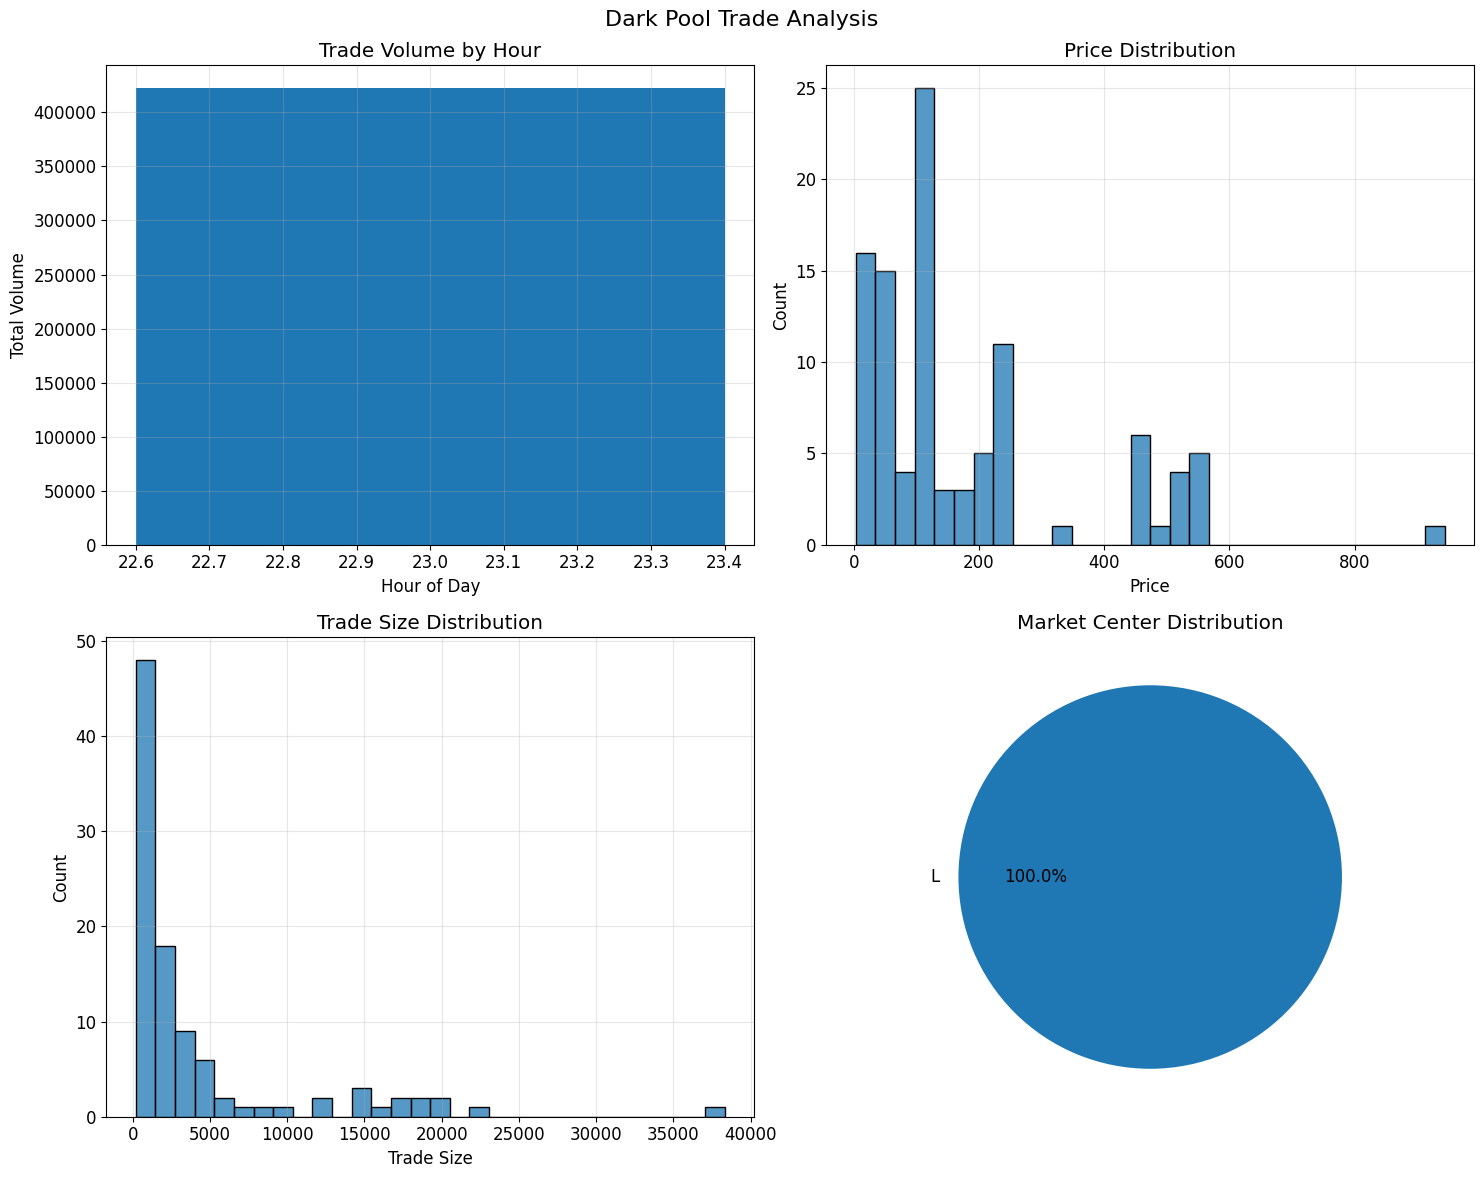

In [24]:
# Cell 5: Execution Cell
# Fetch trades from last trading day
logger.info("Fetching dark pool trades from last trading day...")
trades_df = fetcher.fetch_last_trading_day_trades()  # This will default to last trading day

if not trades_df.empty:
    # Process trades
    processed_trades = fetcher.process_trades(trades_df)

     # Perform analysis
    analysis = analyze_trades(trades_df)  # Make sure to call analyze_trades first!
    
    # Print summary
    print("\nTrade Analysis Summary:")
    print(f"Total Trades: {analysis['total_trades']:,}")
    print(f"Total Volume: {analysis['total_volume']:,.0f}")
    print(f"Total Premium: ${analysis['total_premium']:,.2f}")
    print(f"Average Trade Size: {analysis['avg_trade_size']:,.2f}")
    print(f"Average Price: ${analysis['avg_price']:.2f}")
    print(f"Price Range: ${analysis['price_range']['min']:.2f} - ${analysis['price_range']['max']:.2f}")
    
    # Create visualizations
    plot_trade_analysis(trades_df, analysis)
    
    # Save analysis results
    results_dir = Path('results')
    results_dir.mkdir(exist_ok=True)
    
    # Save raw data
    trades_df.to_csv(results_dir / 'trades_data.csv', index=False)
    
    # Save analysis
    with open(results_dir / 'analysis_results.json', 'w') as f:
        json.dump(analysis, f, indent=2, default=str)
else:
    print("No trades data available for analysis.")